---
# Image reconstruction in X-ray tomography
---
<center>
Alejando de la Concha Duarte &emsp;&emsp;&emsp; Ana Escobar
</center>

## I. X-ray tomography
<div class="alert alert-block alert-success">
<b>Problem:</b> The measurements $y\in\mathbb{R}^M$ and the sought absorption image $x\in\mathbb{R}^N$ obey the linear relation
\begin{equation}
y=H\bar{x}+w\label{eq1}\tag{1} 
\end{equation}

where
 <ul>
  <li>$w\in\mathbb{R}^M$ is the measurement noise, that we assume i.i.d. Gaussian with variance $\sigma^2$</li>
 <li> The tomography matrix $H\in\mathbb{R}^{MxN}$ is a sparse and encodes the geometry of the measurements</li>
</ul>
</div>


In [1]:
from scipy.io import loadmat
import os 
import numpy as np
from numpy import linalg as LA
from scipy.sparse.linalg import svds, eigs, bicg, LinearOperator
from scipy.linalg import pinv
from scipy.sparse import diags
import copy
from scipy.sparse import *
import time
os.getcwd()

'C:\\Users\\Ana Julia\\Dropbox\\TP4'

**1. Download the projection matrix H and the image x available on the website. Use loadmat from scipy.io in Python to load the arrays, note that H is stored as a sparse matrix.**

In [2]:
H=loadmat(os.getcwd()+"/data/H.mat")
x=loadmat(os.getcwd()+"/data/x.mat")

In [3]:
H=H['H']
x=x['x']

In [4]:
H.shape

(16200, 8100)

In [5]:
x.shape

(8100, 1)

**2.Construct $y$, according to model ([1](#mjx-eqn-eq1)), using $\sigma=1$.**

In [6]:
n,m = H.shape

y  = np.random.normal(size=n).reshape(n,1)
y += H.dot(x)
print(n,m)

16200 8100


**3. Here, $N = 90 × 90$ pixels and $M = 90 × 180$ measurements. Display a 2D
version of $x$ and a 2D version of $y$, also known as sinogram. To do so, in
Matlab, use the reshape function ; in Python, use the reshape method with
option $order=’F’$.**

In [7]:
sinogram_x=x.reshape((90,90),order="F")
sinogram_y=y.reshape((90,180))

In [8]:
import matplotlib.pyplot as plt
plt.imshow(sinogram_x, cmap='gray')
plt.show()

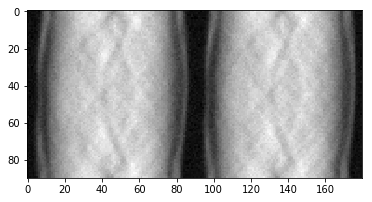

In [9]:
import matplotlib.pyplot as plt
plt.imshow(sinogram_y, cmap='gray', interpolation='nearest')
plt.show()

## II. Optimization problem
<div class="alert alert-block alert-success">
<b>Problem:</b> An efficient strategy to address the reconstruction problem is to define $x$ as a minimizer of an appropriate cost function $f$. More specifically, we focus on the following penalized least-squares criterion :
\begin{equation}
f(x)=\frac{1}{2}\|Hx-y\|^2+\lambda r(x),\qquad \forall x\in\mathbb{R}^n\label{eq2}\tag{2} 
\end{equation}

where
 <ul>
  <li>$r$ r is a regularization function incorporating a priori assumptions to guarantee the robustness of the solution with respect to noise</li>
</ul>
In order to promote images formed by smooth regions separated by sharp edges, we set:
\begin{equation}
r(x)=\displaystyle\sum_{n=1}^{2N}\Psi\left([Gx]^{(n)}\right)\label{eq3}\tag{3} 
\end{equation}
where
<ul>
<li>$G\in\mathbb{R}^{2NxN}$ is a sparse matrix such that $Gx\in\mathbb{R}^{2N}$ is the concatenation of the horizontal and vertical gradients of the image, and ψ is a potential function defined as:
\begin{equation}
    \Psi(u)=\displaystyle\sqrt{1+\frac{u^2}{\delta^2}}\qquad \forall u\in\mathbb{R} \ and\ \delta>0\label{eq4}\tag{4} 
\end{equation}
    </li>
</ul>
</div>


**1. Download the gradient operator G available in the website**

In [10]:
G = loadmat(os.getcwd()+"/data/G.mat")
G = G['G']


non_zeros=csr_matrix(G)[1]
print(type(G), G[:,1])
print(G.shape)

<class 'scipy.sparse.csc.csc_matrix'>   (0, 0)	-1.0
  (1, 0)	1.0
  (8101, 0)	1.0
  (16111, 0)	-1.0
(16200, 8100)


**Give the expression of the gradient $\nabla f$ at some point $x\in\mathbb{R}^N$. Create a function which gives as an output the gradient of $f$ at some input vector $x$.**

\begin{align}
    \Psi'(u) &= \dfrac{d}{du} \sqrt{1+\frac{u^2}{\delta^2}} = \dfrac{u}{\delta^2 \Psi(u)}
    \\
    \nabla f&=H^{\top}(Hx-y)+\lambda \sum_{n=1}^{2N}\Psi'\left([Gx]^{(n)}\right)G^{(n)}
\end{align}

In [59]:
N   = H.shape[1]
x_0 = np.zeros([N,1])
lamda = 0.13;    delta = 0.02

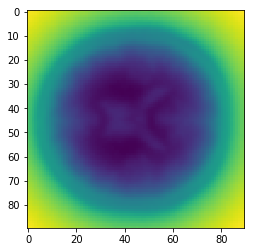

6836974.531231554

In [29]:
def F(x,y,H,G,lamda,delta):
    F_=H.dot(x) ; F_-=y
    F_=0.5*LA.norm(F_)**2 
    F_+=lamda*phi(G.dot(x),delta).sum();
 #   print(phi(G.dot(x),delta))
  #  print(phi(G.dot(x),delta).sum())
    return(F_)

def phi(x,delta):    
    dPn = x;    dPn /= delta
    dPn **= 2;    dPn += 1.0;    dPn **= 0.5
    return(dPn)
        
def phi_prime(x,delta):
    dPn, dPd, a = 0.0, 0.0, 0.0
    a += x;      a /= delta
    
    dPn += a;    dPn /= delta
    dPd += a;    dPd **= 2;    dPd += 1.0;    dPd **= 0.5
    
    dPn /= dPd
    return(dPn)

#def Gx(x,G):    return G.dot(x)

def grad_F(x,y,H,G,lamda,delta):
    Hy   = H.dot(x);    Hy -= y
    HHxy = H.T.dot(Hy)  # m
    Gx   = G.dot(x);
    DPhi = phi_prime(Gx,delta).reshape(1,n)
    
    DF   = G.T.multiply(DPhi).sum(axis=1)
    DF  *= lamda
    DF  += HHxy
    
    #grad=H.T.dot(H.dot(x) -y)+lamda*np.array([np.sum(phi_prime(Gx(x_0,G),delta)[i]*G[:,i].data) for i in range(G.shape[1])])
    #grad=lamda*np.array([np.sum(np.multiply(phi_prime(Gx(x_0,G),delta),(G[:,i]))) for i in range(G.shape[1])])
    return DF

plt.imshow(grad_F(x_0,y,H,G,lamda,delta).reshape(90,90)); plt.show()
#Gx(x_0,G)
#y.shape
F(x_0,y,H,G,lamda,delta).sum()

**Show that a Lipschitz constant of $\nabla f$ is**

\begin{equation}
L=||H||^2+\frac{\lambda}{\delta^2}||G||^2
\end{equation}
Calculate it for the $(\lambda,\delta)$ values given above. Note that, in Matlab, one can use normest to evaluate the norm of a sparse matrix ; in Python, the function scipy.sparse.linalg.svds gives the singular values of a sparse matrix, the maximal singular value being the norm of the matrix

**Solution:**
By the mean value theorem we have:

\begin{equation}
||\nabla f(x)-\nabla f(y)|| \leq ||\nabla^2f|| ||y-x||
\end{equation}

Therefore, it is sufficient to prove that

\begin{equation}
||\nabla^2f|| \leq ||H||^2+\frac{\lambda}{\delta^2}||G||^2
\end{equation}

We calculate the first and second derivatives of $f$ as follows:

$
\begin{align}
\nabla f&=H^{\top}(Hx-y)+\lambda \displaystyle\sum_{n=1}^{2N}\Psi'\left([Gx]^{(n)}\right)G^{(n)}\\
\nabla^2 f&= H^{\top}H+\lambda \displaystyle\sum_{n=1}^{2N}\Psi''\left([Gx]^{(n)}\right)[G^{(n)}G^{(n)\top}]\label{eq5}\tag{5}
\end{align}
$

But, we have that:

\begin{align}
\Psi^{\prime}(u)&=\dfrac{u}{\delta^2\sqrt{1+\frac{u^2}{\delta^2}}}\\
\Psi^{\prime\prime}(u)&=\dfrac{\delta^2\sqrt{1+\frac{u^2}{\delta^2}}-u\left[\frac{\delta^2 u}{\delta^2 \sqrt{1+\frac{u^2}{\delta^2}}}\right]}{\delta^4\left(1+\frac{u^2}{\delta^2}\right)}=\dfrac{\delta^2\left(1+\frac{u^2}{\delta^2}\right)-u^2}{\delta^4\left(1+\frac{u^2}{\delta^2}\right)}
\end{align}

The maximum of the function is reached when $u=0$, then we have that:

\begin{equation}
    \Psi^{\prime\prime}(0)=\frac{1}{\delta^2}
\end{equation}

Replacing in ([5](#mjx-eqn-eq5)), we obtain:

\begin{equation}
\nabla^{2}f=H^{\top}H+\frac{\lambda}{\delta^2} G^{\top}G
\end{equation}

Calculating the norm on both sides, we have


\begin{align}
||\nabla^{2}f||_2&= ||H^{\top}H||_2+\frac{\lambda}{\delta^2} ||G^{\top}G||_2\\
&\leq ||H||_2||H^{\top}||_2+\frac{\lambda}{\delta^2}||G||_2||G||_2\\
&=||H||_2^2+\frac{\lambda}{\delta^2}||G||^2_2
\end{align}



## III. Optimization problem



 ### Gradient descent algorithm

**1. Create $x_0\in\mathbb{R}^N$ a vector with all entries equal to 0. This will be our initialization for all tested algorithms.**


In [30]:
N   = H.shape[1]
x_0 = np.zeros([N,1])
print(x_0.T)

[[0. 0. 0. ... 0. 0. 0.]]


**2. Implement a gradient descent algorithm to minimize $f$**

In [31]:
def cons_lips(lamda,delta,H,G):
    C0  = svds(H,which='LM',k=1, return_singular_vectors='vh')[1];    C0**= 2
    C1  = svds(G,which='LM',k=1, return_singular_vectors='vh')[1];    C1**= 2
    C1 *= lamda/(delta**2);    C0 += C1
    return(C0)

In [32]:
def grad_descent(x_0,y,SN,H,G,L,lamda=0.13,delta=0.02):
    grad_norm = []
    value_=[]
    x_old, x_new = x_0.copy(), x_0.copy();    grad  = grad_F(x_old,y,H,G,lamda,delta) 
    x_new -= L*grad                          #x_new = 1.0*x_old-1.0*L*grad    
   # i=0
    while LA.norm(grad) > SN:
       # i+=1
        value_.append(F(x_new,y,H,G,lamda,delta))
        x_old = x_new.copy();    grad  = grad_F(x_old,y,H,G,lamda,delta) 
        x_new -= L*grad
        grad_norm.append(LA.norm(grad))
        #if i%10==0:
         #   print(value_[i-1])
    #"""
    return(x_new,value_,grad_norm)

In [33]:
L    = cons_lips(lamda,delta,H,G)[0]
prec = np.sqrt(N)*10e-4#np.sqrt(1e-5)*10e-4

start = time.time()
x_s,f_, grad_norm = grad_descent(x_0,y,prec,H,G,1/L,lamda,delta)
end = time.time()
print(np.around(end-start,2))

47.76


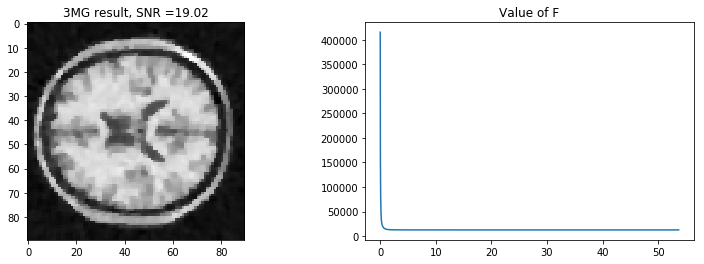

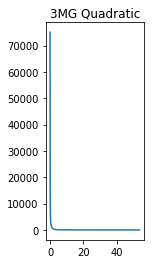

In [64]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_s.reshape(90,90), cmap='gray')
plt.title('3MG result, SNR ='+str( np.around(10*np.log10( x.T.dot(x)[0][0]/( LA.norm(x-x_s)**2 ) ), 3) ))

plt.subplot(1, 3, 2)
plt.plot( np.arange(0,end-start,(end-start)/len(f_)), f_)
plt.title('Value of F');    plt.show()

plt.subplot(1, 3, 3)
plt.plot( np.arange(0,end-start,(end-start)/len(grad_norm)), grad_norm)
plt.title('3MG Quadratic');    plt.show()


 ### MM quadratic algorithm

**Construct, for all $x\in\mathbb{R}$, a quadratic majorant function of $f$ at $x$. Create a function which gives, as an output, the curvature $A(x)$ of the majorant function at an input vector $x$.**

We note:
\begin{align}
f_1&=\frac{1}{2}||H-y||^2\label{eq6}\tag{6}\\
f_2&=\lambda r(x)\label{eq7}\tag{7}\\
f&=f_1+f_2\label{eq8}\tag{8}
\end{align}

We start by finding a majorant function for $f_1$. As $H^{\top}H$ is positive definite, we have that

\begin{equation}
h_1(x,y)=f_1(y)+\langle\nabla f_1(y)|x-y\rangle+\frac{1}{2}\langle x-y|H^{\top}H(x-y)\rangle
\end{equation}

For the $f_2$ we have:

\begin{equation}
r(x)=\displaystyle\sum_{n=1}^{2N} \Psi\left([Gx]^{(n)}\right)
\end{equation}

we note $x^{(n)}=[Gx]^{(n)}$, then by $f_2$

\begin{equation}
h_2^{(n)}(x^{(n)},y^{(n)})=\Psi(y^{n})+\Psi'(y^{(n)})\cdot(x^{(n)}-y^{(n)})+\frac{1}{2}\dfrac{\Psi(y^{(n)})}{y^{(n)}}(x^{(n)}-y^{(n)})^2
\end{equation}
then 

\begin{equation}
h_2(x,y)=r(y)+\langle\nabla r,x-y\rangle +\frac{1}{2}(x-y)^{\top}G^{\top}DG(x-y)
\end{equation}

Finally, we have that $h_1+\lambda h_2$ is a majorant function for $f$ with curvature definite as follows:

\begin{equation}
A(x)=H^{\top}H +\lambda G^{\top}D(Gx)G
\end{equation}

where, $D(Gx)=\text{diag}\left\{\left(\dfrac{\Psi'(|Gx|)}{|Gx|_i}\right)_i\right\}$. Here we notice that
\begin{align}
    \dfrac{1}{|u|}\Psi'(|u|) &= \dfrac{1}{\delta^2 \Psi(|u|)} = \dfrac{1}{\delta^2} \left( 1 + \dfrac{|u|^2}{\delta^2} \right)^{-1/2}
\end{align}

In [60]:
def Phi_prime(x,delta):
    a = 0.0
    a += x;      a /= delta;    a **= 2;    a += 1.0;    a **= -0.5
    a /= delta**2
    return(a.flatten())


In [61]:
def Dx(x,delta):
    arg = Phi_prime(np.abs(x),delta)
    return diags(arg).tocsc()


In [62]:
def Axy(x):
    def result(z):
        Ah  = H.T.dot(H.dot(z));    Ag  = G.T.dot(Dx(G.dot(x),delta)).dot( G.dot(z) );    Ag *= lamda;    Ah += Ag
        return Ah
    return(result)
A = lambda x: LinearOperator((N, N), matvec = Axy(x), rmatvec = Axy(x))

**Deduce a MM quadratic algorithm to minimize f. Implement it.**

In [26]:
#import copy
def MM_quadratic(x_0,y,prec,H,G,L=1,lamda=0.13,delta=0.02):
    grad_norm = []
    x_old, x_new = x_0.copy(), x_0.copy();    dF = grad_F(x_old,y,H,G,lamda,delta) 
    print(LA.norm(dF))
    value_=[]
    n,m=H.shape
    grad = bicg(A(x_old),dF)[0].reshape(-1, 1)#, x0=x_0, tol=1e-4)[0]
    #print(grad) 
    x_new -= L*grad.reshape(m,1)
    i=0
    value_=[]
    #"""
    while LA.norm(dF) > prec:    #LA.norm(x_new-x_old) > prec :
        i+=1
        value_.append(F(x_new,y,H,G,lamda,delta))
        x_old  = x_new.copy();    dF = grad_F(x_old,y,H,G,lamda,delta) 
        value_.append(F(x_new,y,H,G,lamda,delta))
        grad = bicg(A(x_old),dF)[0].reshape(-1, 1)#, x0=x_0, tol=1e-10)[0]
        x_new -= L*grad.reshape(m,1)
        
        grad_norm.append(LA.norm(dF))
        if i%10==0:
            print(grad_norm[i-1])
    #"""
    return(x_new,value_, grad_norm)


In [63]:
start = time.time()
prec=np.sqrt(N)*10e-4
x_s,f_, grad_norm = MM_quadratic(x_0,y,prec,H,G,1.0)
end = time.time()
print(np.around(end-start,2))


449292.7896689747
15.475749568191207
1.9269996256181228
0.434451996440293
0.12966005328358474
36.25


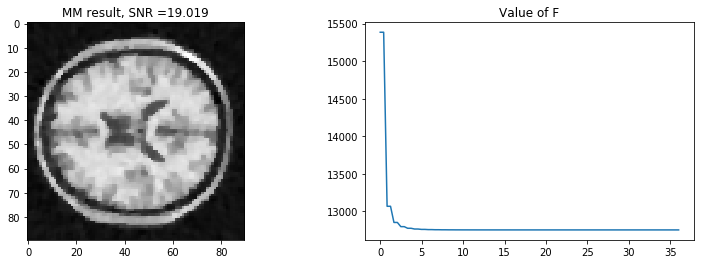

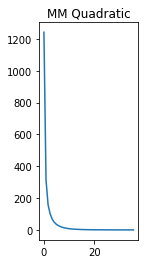

In [81]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_s.reshape(90,90), cmap='gray')
plt.title('MM result, SNR ='+str( np.around(10*np.log10( x.T.dot(x)[0][0]/( LA.norm(x-x_s)**2 ) ), 3) ))

plt.subplot(1, 3, 2)
plt.plot( np.arange(0,end-start,(end-start)/len(f_)), f_)
plt.title('Value of F');    plt.show()


plt.subplot(1, 3, 2)
plt.plot( np.arange(0,end-start,(end-start)/len(grad_norm)), grad_norm)
plt.title('MM Quadratic');    plt.show()

 ###  3MG algorithm


In [28]:
def DAxD(x,H,D,G,lamda): 
    DH=(H.dot(D));       DHHD=DH.T.dot(DH)
    GDD=G.dot(D).T.dot(Dx(G.dot(x),delta).toarray()).dot(G.dot(D)); 
    DHHD=DHHD+GDD
    return(DHHD)
def A3MG_quadratic(x_0,y,prec,H,G,L=1,lamda=0.13,delta=0.02):
    grad_norm = []
    x_old, x_new = x_0.copy(), x_0.copy();    dF = grad_F(x_old,y,H,G,lamda,delta) 
    D_k=-dF
    u_k=-1.0*pinv(DAxD(x_old,H,D_k,G,lamda))
    u_k=u_k.dot(D_k.T.dot(dF))
    x_new +=D_k.dot(u_k)
    value_=[]
    #"""
    while LA.norm(dF) > prec:    #LA.norm(x_new-x_old) > prec :
        value_.append(F(x_new,y,H,G,lamda,delta))
        x_old_old,x_old  = x_old.copy(),x_new.copy();    dF = grad_F(x_old,y,H,G,lamda,delta) 
        D_k=np.concatenate((dF,x_old-x_old_old),axis=1)
        u_k=-1.0*pinv(DAxD(x_old,H,D_k,G,lamda))
        u_k=u_k.dot(D_k.T.dot(dF))
        x_new +=D_k.dot(u_k)
        
        grad_norm.append(LA.norm(dF))
    #"""
    return(x_new,value_, grad_norm)

In [70]:
start = time.time()
prec=np.sqrt(N)*10e-4
x_s,f_, grad_norm = A3MG_quadratic(x_0,y,prec,H,G)
end = time.time()
print(np.around(end-start,2))

353.68


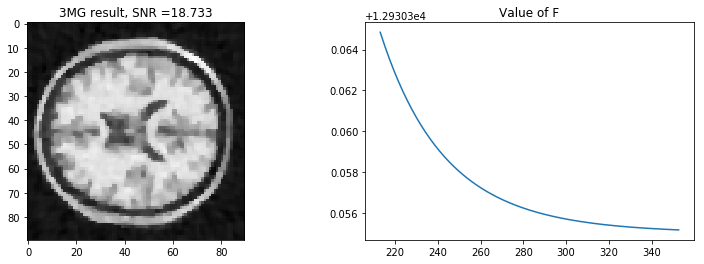

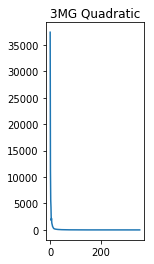

In [71]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_s.reshape(90,90), cmap='gray')
plt.title('3MG result, SNR ='+str( np.around(10*np.log10( x.T.dot(x)[0][0]/( LA.norm(x-x_s)**2 ) ), 3) ))

plt.subplot(1, 3, 2)
plt.plot( np.arange(0,end-start,(end-start)/len(f_))[200:], f_[200:])
plt.title('Value of F');    plt.show()

plt.subplot(1, 3, 3)
plt.plot( np.arange(0,end-start,(end-start)/len(grad_norm)), grad_norm)
plt.title('3MG Quadratic');    plt.show()

 ###  Block-coordinate MM quadratic algorithm

**Create a function which gives, as an output, matrix $A_j(x)\in\mathbb{R}^{N_jxN_j}$ containing only the lines and rows of $A(x)$ with indexes $\mathbb{J}_j$**

In [29]:
J=3
k=3
j=(k-1)%J+1
def get_J(j,N,K):
    Nj=int(N/(K))
    #print(Nj)
    return(Nj*(j-1),j*Nj)
    
def Axj(x,G,H,j,K):
    #Ah  = H.T.dot(H)
    N=H.shape[1]
    ini,end=get_J(j,N,K)
    H_aux=H[:,ini:end]
    G_aux=G[:,ini:end]
    Ah  = H_aux.T.dot(H_aux)
    Ag  = G_aux.T.dot(Dx(G.dot(x),delta).dot(G_aux))
    Ag *= lamda
    Ah += Ag
    return(Ah)

In [69]:
def MM_block(x_0,y,prec,H,G,K,L=1,lamda=0.13,delta=0.02):
    grad_norm = []
    N=H.shape[1]
    j=1
    ini,end=get_J(j,N,K)
    #print(ini,end)
    x_old, x_new = x_0.copy(), x_0.copy();    dF = grad_F(x_old,y,H,G,lamda,delta)
    if(K==1):
        return(MM_quadratic(x_0,y,prec,H,G,L,lamda,delta))

    Aj=Axj(x_old,G,H,j,K)
    m=end-ini
    grad = bicg(Aj,dF[ini:end] )[0]
    x_new[ini:end]-= L*grad.reshape(m,1)#[ini:end]
    value_=[]
    #"""
    i=2
    l=0
    while LA.norm(dF) > prec:    #LA.norm(x_new-x_old) > prec :
        j=(i-1)%K+1
        value_.append(F(x_new,y,H,G,lamda,delta))
        ini,end=get_J(j,N,K)
        x_old = x_new.copy();    dF = grad_F(x_old,y,H,G,lamda,delta)
        Aj=Axj(x_old,G,H,j,K)
        grad = bicg(Aj,dF[ini:end])[0]
        x_new[ini:end]-= L*grad.reshape(m,1)#[ini:end]
        grad_norm.append(LA.norm(dF))
        if l%10==0:
            print(grad_norm[l])
        i+=1
        l+=1
        
            #"""   
    return(x_new,value_, grad_norm)

In [31]:
start = time.time()
prec=np.sqrt(N)*10e-4
x_s,f_, grad_norm = MM_block(x_0,y,prec,H,G,1)
end = time.time()
print(np.around(end-start,2))

449472.78397364327
16.640298266683512
2.2802098048836577
0.5399169118606906
0.1573036643758315
36.55


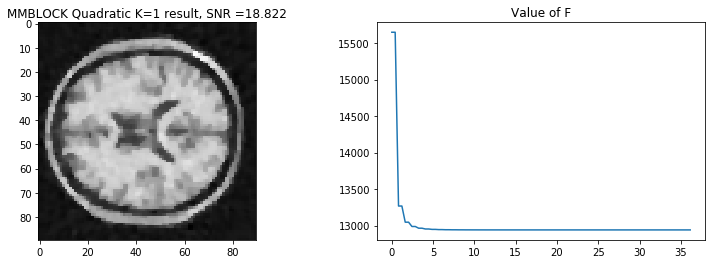

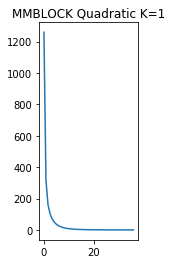

In [32]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_s.reshape(90,90), cmap='gray')
plt.title('MMBLOCK Quadratic K=1 result, SNR ='+str( np.around(10*np.log10( x.T.dot(x)[0][0]/( LA.norm(x-x_s)**2 ) ), 3) ))

plt.subplot(1, 3, 2)
plt.plot( np.arange(0,end-start,(end-start)/len(f_)), f_)
plt.title('Value of F');    plt.show()

plt.subplot(1, 3, 3)
plt.plot( np.arange(0,end-start,(end-start)/len(grad_norm)), grad_norm)
plt.title('MMBLOCK Quadratic K=1');    plt.show()

In [43]:
start = time.time()
prec=np.sqrt(N)*10e-4
x_s,f_, grad_norm = MM_block(x_0,y,prec,H,G,2)
end = time.time()
print(np.around(end-start,2))

153416.98591375793
3845.9579397121306
774.4137109977868
94.23124287295697
11.074174501076378
2.6154069780083082
0.9799288413606031
0.4178118062742235
0.20288506859366742
0.10700478715466638
299.71


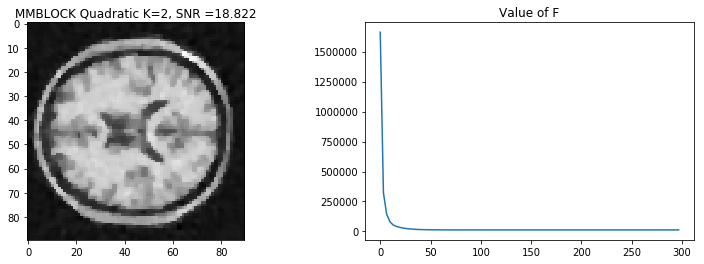

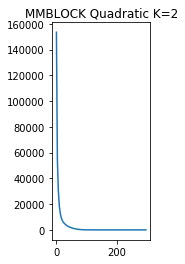

In [44]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_s.reshape(90,90), cmap='gray')
plt.title('MMBLOCK Quadratic K=2, SNR ='+str( np.around(10*np.log10( x.T.dot(x)[0][0]/( LA.norm(x-x_s)**2 ) ), 3) ))

plt.subplot(1, 3, 2)
plt.plot( np.arange(0,end-start,(end-start)/len(f_)), f_)
plt.title('Value of F');    plt.show()

plt.subplot(1, 3, 3)
plt.plot( np.arange(0,end-start,(end-start)/len(grad_norm)), grad_norm)
plt.title('MMBLOCK Quadratic K=2');    plt.show()

In [41]:
start = time.time()
prec=np.sqrt(N)*10e-4
x_s,f_, grad_norm = MM_block(x_0,y,prec,H,G,3)
end = time.time()
print(np.around(end-start,2))

236088.01353070766
6990.136275245537
2664.197045916455
432.1707010668838
119.89499605135384
22.386767210517743
8.222053749652314
3.3389585279035536
1.7425206485806373
1.0607844011143186
0.6515696139096814
0.38805349801757144
0.2473920295079577
0.15856436743086424
0.09993760397328182
185.97


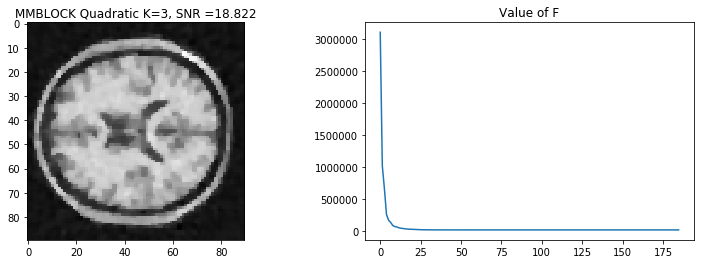

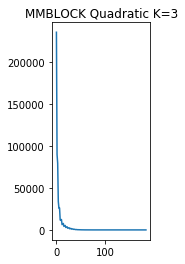

In [42]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_s.reshape(90,90), cmap='gray')
plt.title('MMBLOCK Quadratic K=3, SNR ='+str( np.around(10*np.log10( x.T.dot(x)[0][0]/( LA.norm(x-x_s)**2 ) ), 3) ))

plt.subplot(1, 3, 2)
plt.plot( np.arange(0,end-start,(end-start)/len(f_)), f_)
plt.title('Value of F');    plt.show()

plt.subplot(1, 3, 3)
plt.plot( np.arange(0,end-start,(end-start)/len(grad_norm)), grad_norm)
plt.title('MMBLOCK Quadratic K=3');    plt.show()

In [39]:
start = time.time()
prec=np.sqrt(N)*10e-4
x_s,f_, grad_norm = MM_block(x_0,y,prec,H,G,5)
end = time.time()
print(np.around(end-start,2))

306276.37131985085
13385.093701692134
5184.91345320951
2595.534370733785
1273.5263057095692
483.12492501405933
156.80612356465787
61.58811258335993
28.197302621586864
13.769497473100401
7.381338971953775
4.4252668107434605
2.890137741890812
1.989718731025786
1.4154026133598576
1.0298390804690989
0.762183950074942
0.5717839219715299
0.43370747961335826
0.3319866170962134
0.2560623389174401
0.19876927691904625
0.15513629243305335
0.12164758374605986
0.09577461654387208
127.71


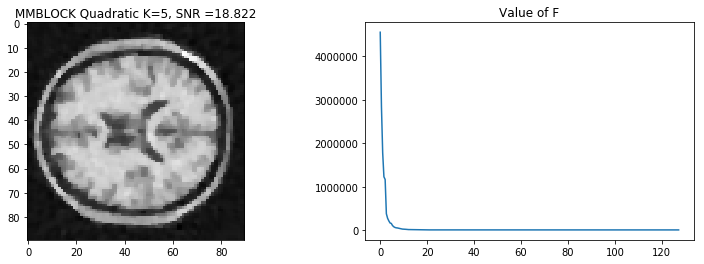

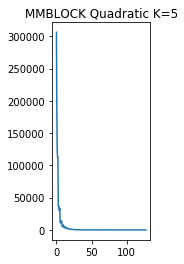

In [40]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_s.reshape(90,90), cmap='gray')
plt.title('MMBLOCK Quadratic K=5, SNR ='+str( np.around(10*np.log10( x.T.dot(x)[0][0]/( LA.norm(x-x_s)**2 ) ), 3) ))

plt.subplot(1, 3, 2)
plt.plot( np.arange(0,end-start,(end-start)/len(f_)), f_)
plt.title('Value of F');    plt.show()

plt.subplot(1, 3, 3)
plt.plot( np.arange(0,end-start,(end-start)/len(grad_norm)), grad_norm)
plt.title('MMBLOCK Quadratic K=5');    plt.show()

In [37]:
start = time.time()
prec=np.sqrt(N)*10e-4
x_s,f_, grad_norm = MM_block(x_0,y,prec,H,G,6)
end = time.time()
print(np.around(end-start,2))

322268.1587707587
32456.141071144288
4679.2729796197455
4471.155179935113
1454.6760674292073
813.5300279723422
377.1623825606733
169.1228165388365
95.01307486021551
33.460917707819526
20.496554309036643
12.099859156915818
7.402801563807242
5.284979874356985
3.5937126715263
2.589324053305503
1.9592357544720875
1.4691029803868603
1.1072047331325114
0.8617410720381691
0.6815874440899874
0.5269262267943731
0.4171810855748587
0.33975883086213526
0.26736275358005923
0.21473640804279823
0.17811584090251606
0.14200787620356908
0.11546163115186801
0.09700768434197846
110.13


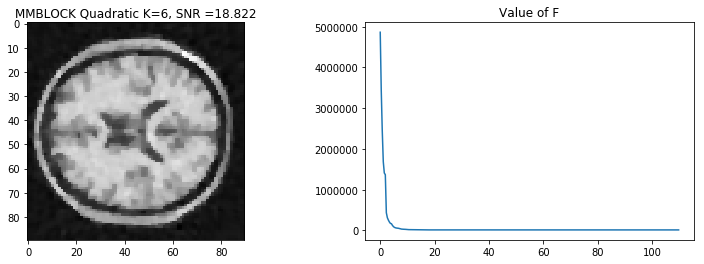

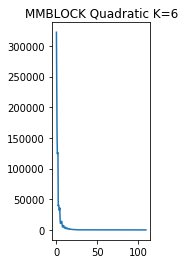

In [38]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_s.reshape(90,90), cmap='gray')
plt.title('MMBLOCK Quadratic K=6, SNR ='+str( np.around(10*np.log10( x.T.dot(x)[0][0]/( LA.norm(x-x_s)**2 ) ), 3) ))

plt.subplot(1, 3, 2)
plt.plot( np.arange(0,end-start,(end-start)/len(f_)), f_)
plt.title('Value of F');    plt.show()

plt.subplot(1, 3, 3)
plt.plot( np.arange(0,end-start,(end-start)/len(grad_norm)), grad_norm)
plt.title('MMBLOCK Quadratic K=6');    plt.show()

In [35]:
start = time.time()
prec=np.sqrt(N)*10e-4
x_s,f_, grad_norm = MM_block(x_0,y,prec,H,G,9)
end = time.time()
print(np.around(end-start,2))

347375.17398420983
46858.09087275381
14470.922493553344
8060.688147358066
4357.376272818585
2799.4428415905677
1717.4741110808852
931.5583193303872
436.9779613354216
254.30926931742033
158.647300561166
117.52117137350142
60.96953542180547
36.96210121710989
25.689331689603193
19.13691229514222
13.365113809926278
7.730620722786236
5.727348052271685
4.554601248353723
3.544824700128689
2.8835445062942466
2.370368022057941
1.944553000340885
1.6192564623068617
1.3369031317573983
1.0587714266942672
0.9040051405527542
0.7547537010077898
0.6447031858880778
0.5537651116609624
0.4781949959770934
0.40972689567233106
0.35031947125772006
0.30129030157171044
0.2589288395428307
0.22767994409308034
0.19205002429427168
0.16901828252562273
0.14889941346362304
0.1314160487930078
0.11495779739760756
0.10084915591427251
81.19


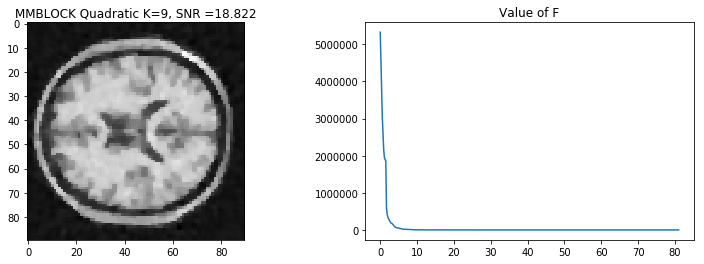

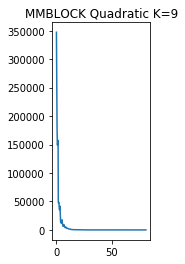

In [36]:
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(x_s.reshape(90,90), cmap='gray')
plt.title('MMBLOCK Quadratic K=9, SNR ='+str( np.around(10*np.log10( x.T.dot(x)[0][0]/( LA.norm(x-x_s)**2 ) ), 3) ))

plt.subplot(1, 3, 2)
plt.plot( np.arange(0,end-start,(end-start)/len(f_)), f_)
plt.title('Value of F');    plt.show()

plt.subplot(1, 3, 3)
plt.plot( np.arange(0,end-start,(end-start)/len(grad_norm)), grad_norm)
plt.title('MMBLOCK Quadratic K=9');    plt.show()

## 3.6 Comparison of the methods

**1.Create a function that computes the value of the criterion f along the iterations of the algorithm.**
**2.What is the required time for each method to achieve this condition ? For
each method, plot the decrease of $f(x_k))_{k\in\mathbb{N}}$ versus time until the stopping
criterion is satisfied.**

| Algorithm                | Computation time | SNR    |
|--------------------------|------------------|--------|
| Gradient descent         | 53.65            | 19.02  |
| MM Quadratic             | 36.24            | 19.019 |
| 3MG Quadratic            | 353.68           | 18.733 |
| Block-coordinate MM k=1* | 36.55            | 18.822 |
| Block-coordinate MM k=2  | 299.71           | 18.822 |
| Block-coordinate MM k=3  | 185.97           | 18.822 |
| Block-coordinate MM k=5  | 127.71           | 18.822 |
| Block-coordinate MM k=6  | 110.13           | 18.822 |
| Block-coordinate MM k=9  | 81.19            | 18.822 |

* It was impossible to obtain the matrix product $H^{T}H$ because of memory issues, then, we were forced to keep the linear operator in this case. However, for the remaining values of K, we followed the suggestion of using the matrix $A_j(x)$

We can see how the strategy of Blook-coordinate reduces the time of computation as K increases. Nevertheless as we were using matrices instead of linear operators, we cannot see an improvement over the MM Quadratic algorithm as expected. 

From all strategies, the ones with the best computation time were MM Quadratic and Gradient Descent, which also had the highest values for SNR. We continued the exercise with the MM Quadratic algorithm. 

In [53]:
def SNR(x,x_sol):
    return(np.around(10*np.log10(LA.norm(x)**2/( LA.norm(x-x_sol)**2 ) ), 3))

**3. The Signal to Noise Ration (SNR) of a restored image xb is defined as
\begin{equation}
SNR =10\log_{10}\left(\dfrac{||\bar{x}||^2}{||\bar{x}-\hat{x}||^2}\right)
\end{equation}
Using the fastest method, search for parameters (λ, δ) that optimize the SNR.**

We tried different combinations of the parameter $\lambda$ and $\delta$, but we were not able to find a better solution than the one with the suggested values. 

In [55]:
lamda_list=[0.13,0.15]
d=[0.01,0.02,0.05]
from itertools import product
lamda_d=product(lamda_list,d)
#lamda_d=[list(x) for x in lamda_d]
results=[]
for lam,delt in lamda_d:
    lamda = lam;    delta =delt
    def Axy(x):
        def result(z):
            Ah  = H.T.dot(H.dot(z));    Ag  = G.T.dot(Dx(G.dot(x),delta)).dot( G.dot(z) );    Ag *= lamda;    Ah += Ag
            return Ah
        return(result)
    A = lambda x: LinearOperator((N, N), matvec = Axy(x), rmatvec = Axy(x))
    results.append(MM_quadratic(x_0,y,prec,H,G,1,lamda,delta)[0])
    

449292.7896689747
66.93341295934589
14.898080849949338
5.220207460062829
2.189446337921808
1.025749339556079
0.520493075375882
0.27906300755895863
0.15542957686235548
0.08903285826755092
449292.7896689747
15.475749568191207
1.9269996256181228
0.434451996440293
0.12966005328358474
449292.7896689747
1.277335675473243
449292.7896689747
79.10948642241175
18.592481406637432
6.722446208938156
2.9487587877263577
1.4493234621445008
0.7599783197076723
0.41362013270233877
0.23061693589720894
0.13089828143840881
449292.7896689747
18.767799891012025
2.4121385299709757
0.5595698614728694
0.17466158368921544
449292.7896689747
1.502261122711314
0.07322699984201755


In [56]:
[SNR(x,item) for item in results]

[17.85, 18.844, 17.218, 17.579, 18.805, 17.711]